In [ ]:
! pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url='https://www.kaggle.com/datasets/ziya07/iot-secure-routing-dataset-for-intrusion-detection'
od.download(dataset_url)

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [ ]:
df= pd.read_csv('/content/iot-secure-routing-dataset-for-intrusion-detection/iot_routing_intrusion_dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Packet_ID         10000 non-null  int64  
 1   Timestamp         10000 non-null  object 
 2   Source_Node       10000 non-null  object 
 3   Destination_Node  10000 non-null  object 
 4   Packet_Size       10000 non-null  int64  
 5   Protocol          10000 non-null  object 
 6   Encryption_Type   10000 non-null  object 
 7   Hash_Match        10000 non-null  object 
 8   Packet_Delay(ms)  10000 non-null  float64
 9   Attack_Type       10000 non-null  object 
 10  Is_Attack         10000 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 859.5+ KB


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')

# Nodes encoding

In [ ]:
srs_node = df['Source_Node'].unique()
dst_node= df['Destination_Node'].unique()
all_nodes = np.concatenate((srs_node, dst_node))
le = LabelEncoder()
all_nodes_Encoder = le.fit(all_nodes)
df['Source_Node'] = all_nodes_Encoder.transform(df['Source_Node'])
df['Destination_Node'] = all_nodes_Encoder.transform(df['Destination_Node'])

# Protocol, Encryption_Type, Hash_Match, Attack_Type encoding

In [ ]:
le_proto = LabelEncoder()
df['Protocol'] = le_proto.fit_transform(df['Protocol'])

le_enc = LabelEncoder()
df['Encryption_Type'] = le_enc.fit_transform(df['Encryption_Type'])

le_hash = LabelEncoder()
df['Hash_Match'] = le_hash.fit_transform(df['Hash_Match'])

le_attack = LabelEncoder()
df['Attack_Type'] = le_attack.fit_transform(df['Attack_Type'])

In [ ]:
le_attack

LabelEncoder()

# Dataset spliting

In [ ]:
X = df.drop(['Packet_ID', 'Timestamp', 'Is_Attack', 'Attack_Type'], axis=1)
y = df['Attack_Type']

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Packet size and Packet delay scaling

In [ ]:
features = ['Packet_Size', 'Packet_Delay(ms)']

In [ ]:
preprocessor = ColumnTransformer(
        transformers=[
            ('scaler_robuste', RobustScaler(), features)
        ],
        remainder='passthrough'
    )

# Model taining and evaluation

In [ ]:
def evaluate_pipeline(pipeline):
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }

    results = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)

    print("===== Validation Cross-Validation Scores =====")

    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        scores = results[f'test_{metric}']
        print(f"\n{metric.capitalize()} per fold:")
        for i, score in enumerate(scores, 1):
            print(f"  Fold {i}: {score:.4f}")
        print(f"  Mean {metric.capitalize()}: {np.mean(scores):.4f}")

    return results


# Random forest

In [ ]:
pipeline = Pipeline([
        ('preprocesseur', preprocessor),
        ('classifieur', RandomForestClassifier(random_state=42))
    ])

In [ ]:
evaluate_pipeline(pipeline)

===== Validation Cross-Validation Scores =====

Accuracy per fold:
  Fold 1: 0.8935
  Fold 2: 0.8875
  Fold 3: 0.8845
  Fold 4: 0.8925
  Fold 5: 0.8845
  Mean Accuracy: 0.8885

Precision per fold:
  Fold 1: 0.8713
  Fold 2: 0.8614
  Fold 3: 0.8551
  Fold 4: 0.8680
  Fold 5: 0.8554
  Mean Precision: 0.8623

Recall per fold:
  Fold 1: 0.8935
  Fold 2: 0.8875
  Fold 3: 0.8845
  Fold 4: 0.8925
  Fold 5: 0.8845
  Mean Recall: 0.8885

F1 per fold:
  Fold 1: 0.8800
  Fold 2: 0.8730
  Fold 3: 0.8672
  Fold 4: 0.8781
  Fold 5: 0.8683
  Mean F1: 0.8733


{'fit_time': array([1.22245741, 0.97272921, 0.95692682, 0.9702878 , 0.99569964]),
 'score_time': array([0.04588985, 0.04629064, 0.04615593, 0.04467535, 0.04767799]),
 'test_accuracy': array([0.8935, 0.8875, 0.8845, 0.8925, 0.8845]),
 'test_precision': array([0.87130772, 0.86138516, 0.8550811 , 0.86804812, 0.85543721]),
 'test_recall': array([0.8935, 0.8875, 0.8845, 0.8925, 0.8845]),
 'test_f1': array([0.88004927, 0.87301144, 0.86724538, 0.87813913, 0.86827527])}

# XGboost model

In [ ]:
pipeline_XGB = Pipeline([
        ('preprocesseur', preprocessor),
        ('classifieur',  XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))
    ])

In [ ]:
evaluate_pipeline(pipeline_XGB, X,y, skf)

===== Validation Cross-Validation Scores =====

Accuracy per fold:
  Fold 1: 0.8925
  Fold 2: 0.8885
  Fold 3: 0.8900
  Fold 4: 0.8910
  Fold 5: 0.8905
  Mean Accuracy: 0.8905

Precision per fold:
  Fold 1: 0.8683
  Fold 2: 0.8636
  Fold 3: 0.8626
  Fold 4: 0.8662
  Fold 5: 0.8652
  Mean Precision: 0.8652

Recall per fold:
  Fold 1: 0.8925
  Fold 2: 0.8885
  Fold 3: 0.8900
  Fold 4: 0.8910
  Fold 5: 0.8905
  Mean Recall: 0.8905

F1 per fold:
  Fold 1: 0.8783
  Fold 2: 0.8745
  Fold 3: 0.8740
  Fold 4: 0.8766
  Fold 5: 0.8756
  Mean F1: 0.8758


{'fit_time': array([2.35064745, 1.01776147, 0.88462782, 0.37774086, 0.36537075]),
 'score_time': array([0.06825113, 0.05061603, 0.04583859, 0.03471756, 0.03408837]),
 'test_accuracy': array([0.8925, 0.8885, 0.89  , 0.891 , 0.8905]),
 'test_precision': array([0.8683164 , 0.86360617, 0.86262542, 0.8661662 , 0.86521808]),
 'test_recall': array([0.8925, 0.8885, 0.89  , 0.891 , 0.8905]),
 'test_f1': array([0.8782509 , 0.87454686, 0.87398038, 0.87660692, 0.8756254 ])}

# Split 80% train 20% test

In [ ]:
Scaler = RobustScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train[features] = Scaler.fit_transform(X_train[features])
X_test[features] = Scaler.fit_transform(X_test[features])

In [ ]:
XGb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
XGb_model.fit(X_train, y_train)
XGb_pred = XGb_model.predict(X_test)

In [ ]:
print('XGBoost Model Performance on Test Set:')
print(f"Accuracy: {accuracy_score(y_test, XGb_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, XGb_pred))

XGBoost Model Performance on Test Set:
Accuracy: 0.8865

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.19      0.24        90
           1       0.30      0.27      0.29        91
           2       0.95      1.00      0.98      1711
           3       0.29      0.19      0.23       108

    accuracy                           0.89      2000
   macro avg       0.47      0.41      0.43      2000
weighted avg       0.86      0.89      0.87      2000



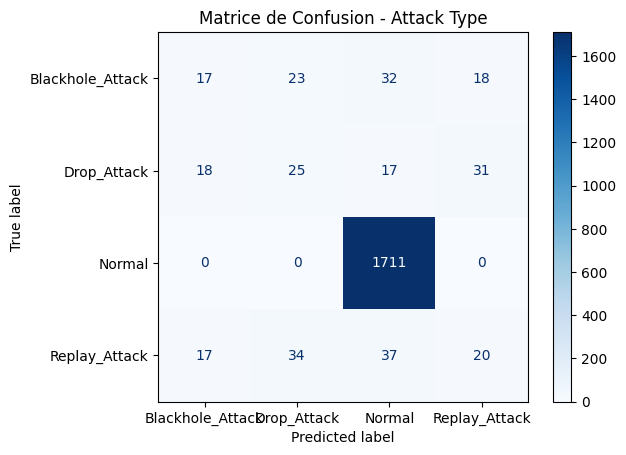

In [ ]:
class_names = le_attack.classes_
cm = confusion_matrix(y_test, XGb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion - Attack Type")
plt.show()

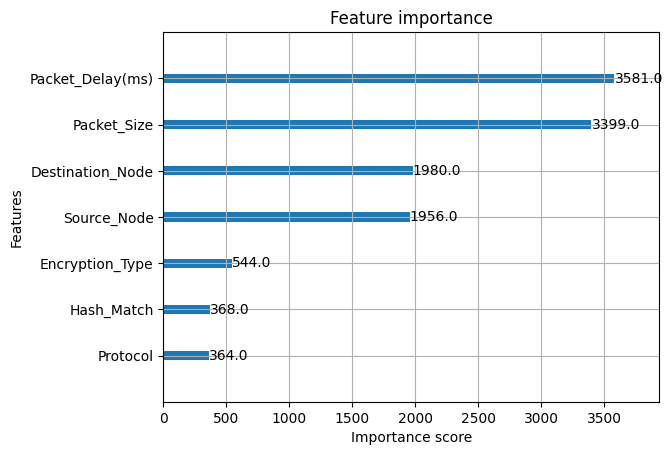

In [ ]:
from xgboost import plot_importance

plot_importance(XGb_model, max_num_features=10, importance_type='weight')  # ou 'gain'/'cover'
plt.show()